In [27]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.io import wavfile as wav
import scipy
import scipy.signal.windows as win

## Punto 1

En primer lugar demodulamos la señal con Fc = 2kHz.

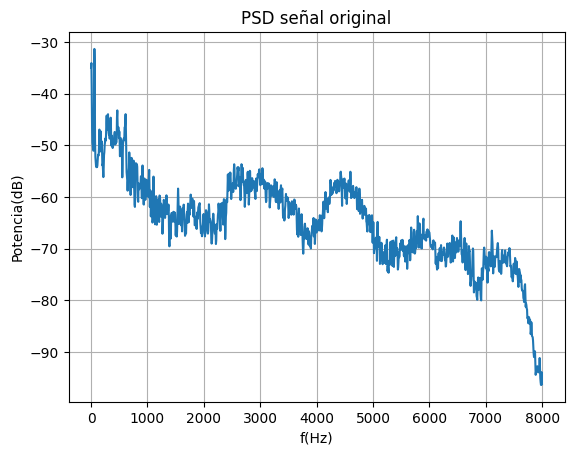

In [48]:
Fc = 2e3
v_sound = 343  # [m/s]

# Distancia entre sensores
dist = [0.04, 0.08, 0.16]

sensors = [[3, 4, 5, 6, 7, 8, 9, 10, 11],
                    [1, 2, 3, 5, 7, 9, 11, 12, 13],
                    [0, 1, 3, 7, 11, 13, 14]]

M = [len(s) for s in sensors]

Fs, signals = wav.read('mtms-arrC1A.wav')

# Acondicionamiento de las señales
data = signals / np.max(signals)

data = np.swapaxes(data, 0, 1)  # Fila son canales, columnas son tiempo

a, b = plt.mlab.psd(data[1], Fs=16000, NFFT=data[0].size//200)
plt.plot(b,10*np.log10(a))
plt.xlabel('f(Hz)')
plt.ylabel('Potencia(dB)')
plt.title('PSD señal original')
plt.grid()

plt.show()

In [56]:
print(wavelength/2, '>', dist[1])

0.08575 > 0.08


Vamos a utilizar el segundo arreglo de sensores pues cumple nyquist espacial y se acerca al criterio óptimo de d<=lambda/2

El ancho de banda del filtrado se eligió para que B sea el 2% de Fc.

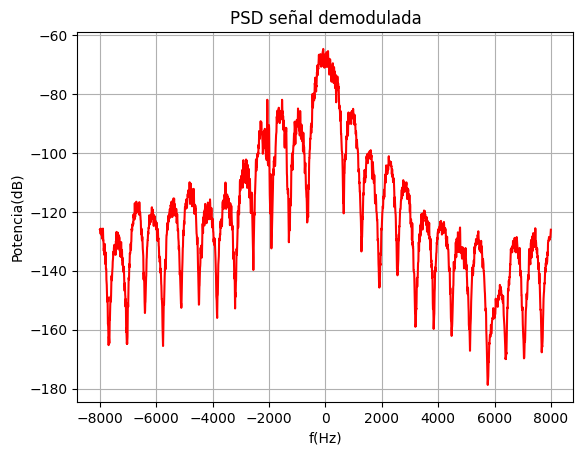

In [49]:

Fs = 16e3
Fc = 2e3
v_sound = 343
wavelength = v_sound/Fc

# Distancia entre sensores
dist = [0.04, 0.08, 0.16]

sensors = [[3, 4, 5, 6, 7, 8,  9, 10, 11],
            [1, 2, 3, 5, 7, 9, 11, 12, 13],
            [0, 1, 3, 7, 11, 13, 14]]

M = [len(s) for s in sensors]

rate, data = wav.read('mtms-arrC1A.wav')
length = data.shape[0] / rate
N = len(data)
data = np.swapaxes(data,0,1) # Fila son canales, columnas son tiempo


data = data / np.max(data)

def demod_and_filter(samples, Fc, Fs, order, B):

    exp_demod = np.exp(-2j*np.pi*Fc/Fs* np.arange( len(samples) )) 
    # estoy bastante seguro de que acá habia un error en tip la consigna, y le faltaba un (-) 
    # al exponente de la exponencial, porque si no no se cumple el -sin de la demodulación que 
    # esta en los apuntes de clase
    samples_demod = exp_demod * samples
    a = 1
    b = signal.firwin(order+1, B, window='bartlett', fs=Fs)
    samples_filt = signal.lfilter(b, a, samples_demod)

    return samples_filt

data_filt = np.zeros(np.shape(data), dtype=np.complex_)
for i, val in enumerate(data):
    data_filt[i] = demod_and_filter(data[i], Fc, Fs, 50, B=2000/50)

a, b = plt.mlab.psd(data_filt[1], Fs=16000, NFFT=data[0].size//200)
plt.title('PSD señal demodulada')
plt.plot(b,10*np.log10(a), 'r')
plt.xlabel('f(Hz)')
plt.ylabel('Potencia(dB)')
plt.grid()

plt.show()

Hacemos un análisis de potencia espacial de la banda de frecuencia deseada. Econtramos que hay dos picos, uno en 0° y uno en 37.5°. Resta analizar cual se corresponde a la voz del locutor y eso lo vamos a hacer analizando fragmentos que solo contengan interferencia. 

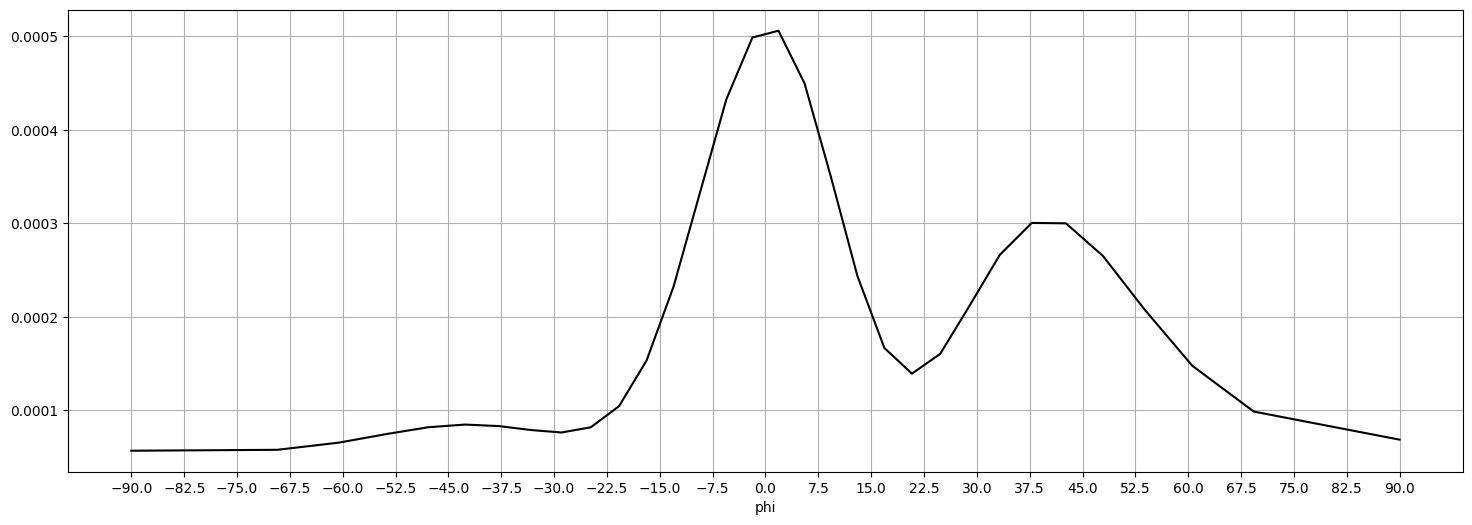

In [50]:
array_idx = 1

data_fft = np.zeros((32, data_filt.shape[1]), dtype=np.complex_)

for t in range(len(data_filt[0])):
    data_fft[:, t], _ = plt.mlab.psd(data_filt[sensors[array_idx] , t], 
                                            Fs=1, 
                                            NFFT=data_filt[sensors[array_idx] , t].size,
                                            pad_to=32,
                                            sides='twosided')
    
data_fft /=  data_filt.shape[1]

plt.figure(figsize=(18, 6))
phi_ax = 180/np.pi * np.arcsin(np.linspace(-1, 1, len(data_fft))) 
plt.plot(phi_ax , np.abs(data_fft).sum(axis=1), 'k')
plt.xticks(np.linspace(-90, 90, 24+1))
plt.xlabel('phi')
plt.grid()
plt.show()

Se tomaron varios segmentos que cumplen con el requerimiento de que el locutor esté en silencio y los pegamos juntos para analizar su potencia espacial.

In [51]:

start = (16000*np.array([22, 25.8, 28.1, 31])).astype(int)
stop = (16000*np.array([23.1,25.8,28.1,31])).astype(int)

i_n_filt = data_filt[ sensors[array_idx]]
interference = np.zeros((9,0))
print(i_n_filt[:, start[1]:stop[1]].shape)
for i, item in enumerate(start):
    interference = np.concatenate((interference, i_n_filt[:, start[i]:stop[i]]), axis=1)

(9, 0)


Analizamos el ángulo de incidencia de la señal interferencia (cuando el locutor no habla). Encontramos que este ángulo es principalmente 37.5°, es decir ese pico en el análisis total de la grabación se debe corresponder con la interferencia. 

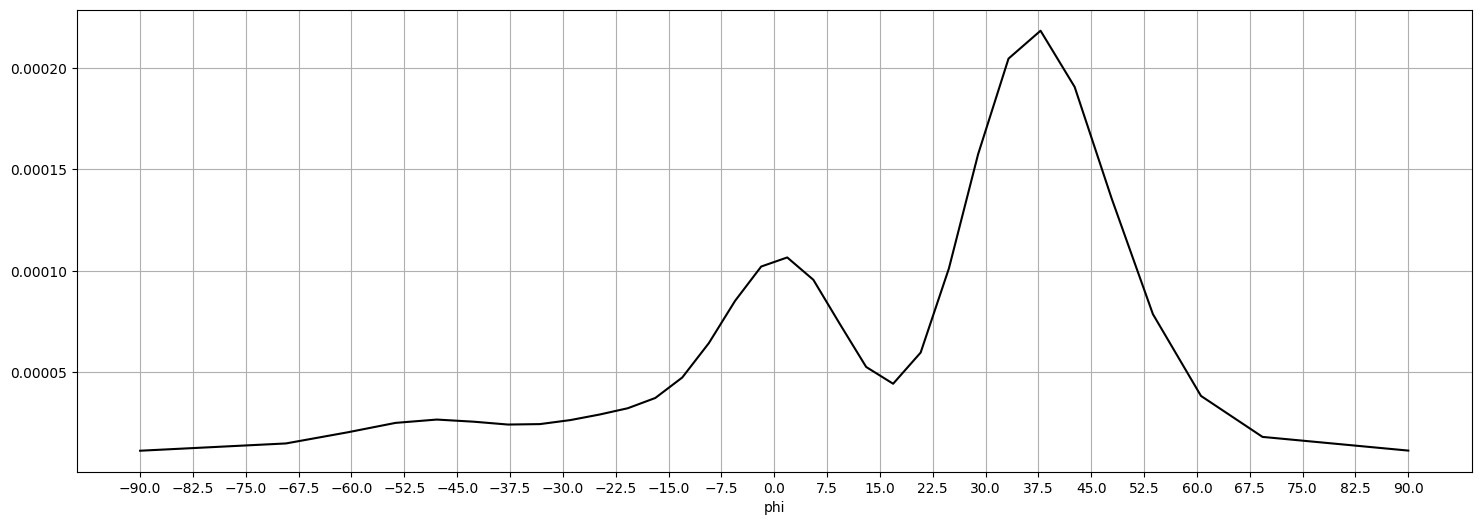

In [52]:
interference_fft = np.zeros((32, interference.shape[1]), dtype=np.complex_)

for t in range(len(interference[0])):
    interference_fft[:, t], _ = plt.mlab.psd(interference[: , t], 
                                            Fs=1, 
                                            NFFT=data_filt[: , t].size,
                                            pad_to=32,
                                            sides='twosided')
interference_fft /= len(interference[0])

plt.figure(figsize=(18, 6))
phi_ax = 180/np.pi * np.arcsin(np.linspace(-1, 1, len(interference_fft))) 
plt.plot(phi_ax , np.abs(interference_fft).sum(axis=1), 'k')
plt.xticks(np.linspace(-90, 90, 24+1))
plt.xlabel('phi')
plt.grid()
plt.show()

A partir del segmento de grabación creamos mediante SMI la matriz R_{in}.

In [53]:

#Creamos a la matriz Ri_n a partir de este segmento de grabación

n = interference.shape[0]
Ri_n = np.zeros((n, n), dtype=np.complex_)

for i in range( interference.shape[1] ):
    R = np.matmul( np.conj(interference[:, i].reshape((n, 1))) , interference[:, i].reshape((1, n)) )
    Ri_n += R

Ri_n = Ri_n / (interference.shape[1])

inv_Rin = np.linalg.inv(Ri_n)

## Punto 2

Finalmente creamos el beamformer que maximice el SINR (y lo comparamos con un beamformer dirigido con phi = 0). 

Vemos que el beamformer óptimo tiene un cero en el ángulo principal en el que la interferencia tiene un pico de energía (37.5°). 

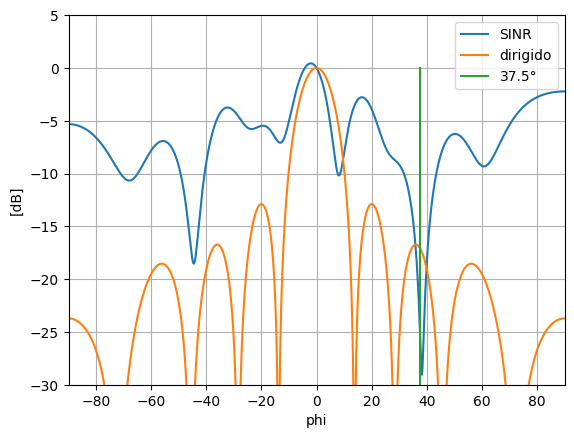

In [58]:
i_n_filt = data_filt[sensors[array_idx]]

wavelength = v_sound/Fc
d = dist[array_idx]
m = M[array_idx]


def response_vector(phi, m, d, wavelength):
    return ( 1/np.sqrt(m) * np.exp(-2j * np.pi * d * np.sin(phi) / wavelength * np.arange(m)) ).reshape((m, 1))

v_s = response_vector(0, m, d, wavelength).reshape(m,1)
v_s_h = np.conj(v_s.transpose())

c_o = np.matmul(inv_Rin,v_s) / np.matmul( np.matmul(v_s_h, inv_Rin), v_s )[0][0]

C = []
for phi in np.linspace(-np.pi/2, np.pi/2, 5000):
    v = response_vector(phi, m, d, wavelength)
    c_o_h = np.conj(c_o.transpose()) 
    C.append((np.dot(c_o_h, v)).flatten())

plt.plot(np.linspace(-90, 90, 5000), 10*np.log10(np.abs(C)**2), label='SINR')

C = []
for phi in np.linspace(-np.pi/2, np.pi/2, 5000):
    v = response_vector(phi, m, d, wavelength)
    c = response_vector(0, m, d, wavelength)
    c_h = np.conj(c.transpose()) 
    C_val = (np.dot(c_h, v)).flatten()
    C.append(C_val)


plt.plot(np.linspace(-90, 90, 5000), 10*np.log10(np.abs(C)**2), label='dirigido')
plt.xlim(-90,90);plt.grid()
plt.xlabel('phi')
plt.ylabel('[dB]')
plt.plot([37.5, 37.5], [-30, 0], label='37.5°')
plt.legend()
plt.ylim(-30,5)

plt.show()